In [178]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [179]:
warnings.filterwarnings('ignore')

In [180]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [181]:
train_df_final.head()

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,hum_pca1,hum_pca2,slp_pca1,slp_pca2,wind_pca1,wind_pca2,cloud_pca1,cloud_pca2,precip_pca1,precip_pca2
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,0.017213,0.999852,1,9.426812,...,-44.174162,0.012243,35.318138,-0.833324,-0.346942,0.820638,-2.017006,-1.935519,1208.941930,752.212943
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,0.034422,0.999407,2,9.437325,...,-48.024363,7.321567,36.785260,0.377317,-1.637682,-0.168122,-6.083274,-0.397254,1483.958436,-550.375188
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,0.051620,0.998667,3,9.448699,...,-52.573928,16.518909,38.582099,0.698330,-1.712214,-1.206722,-6.083274,-0.397254,1489.211203,-550.743985
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,0.068802,0.997630,4,9.460926,...,-31.007499,-15.890927,30.131834,-4.494970,-1.548832,0.075699,-3.781599,1.071908,1289.173590,802.529906
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,0.085965,0.996298,5,9.473997,...,-59.024818,12.811830,22.333693,1.012483,-0.714796,0.030204,-5.558634,-0.909790,1178.303267,-549.019773


# Dataset Splitting

In [182]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [183]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 32,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [184]:
# study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
# study.optimize(objective, n_trials=250, n_jobs=-1)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 32,
#     'verbosity': 0
# })

In [185]:
best_params = {'n_estimators': 7686, 'learning_rate': 0.027367337212669172, 'max_depth': 5, 'subsample': 0.5959315110309751, 'colsample_bytree': 0.901155651474499, 'min_child_weight': 0.0072824350924899, 'gamma': 5.136565597520639e-08, 'reg_alpha': 0.00036520349232711184, 'reg_lambda': 4.6466639093441024}

# Train

In [186]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8416 | RMSE: 1.1916


# Feature Importance

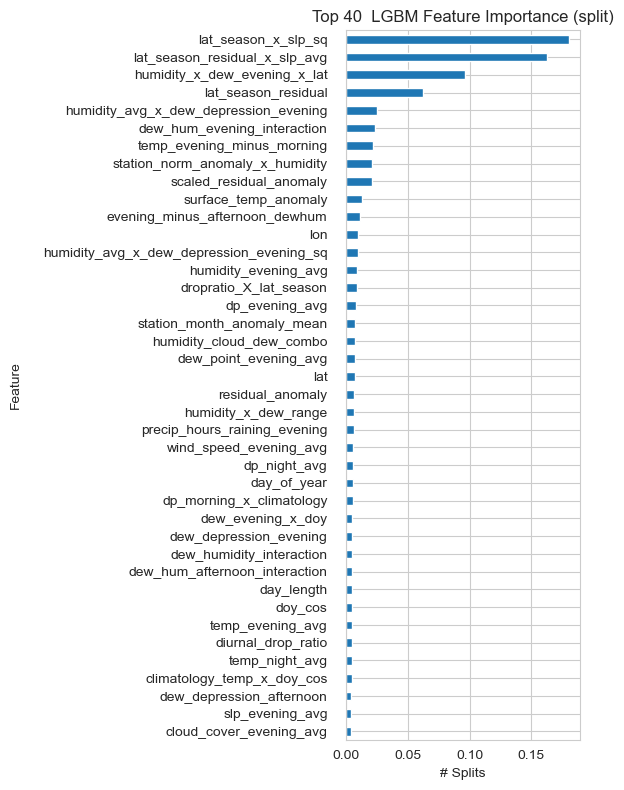

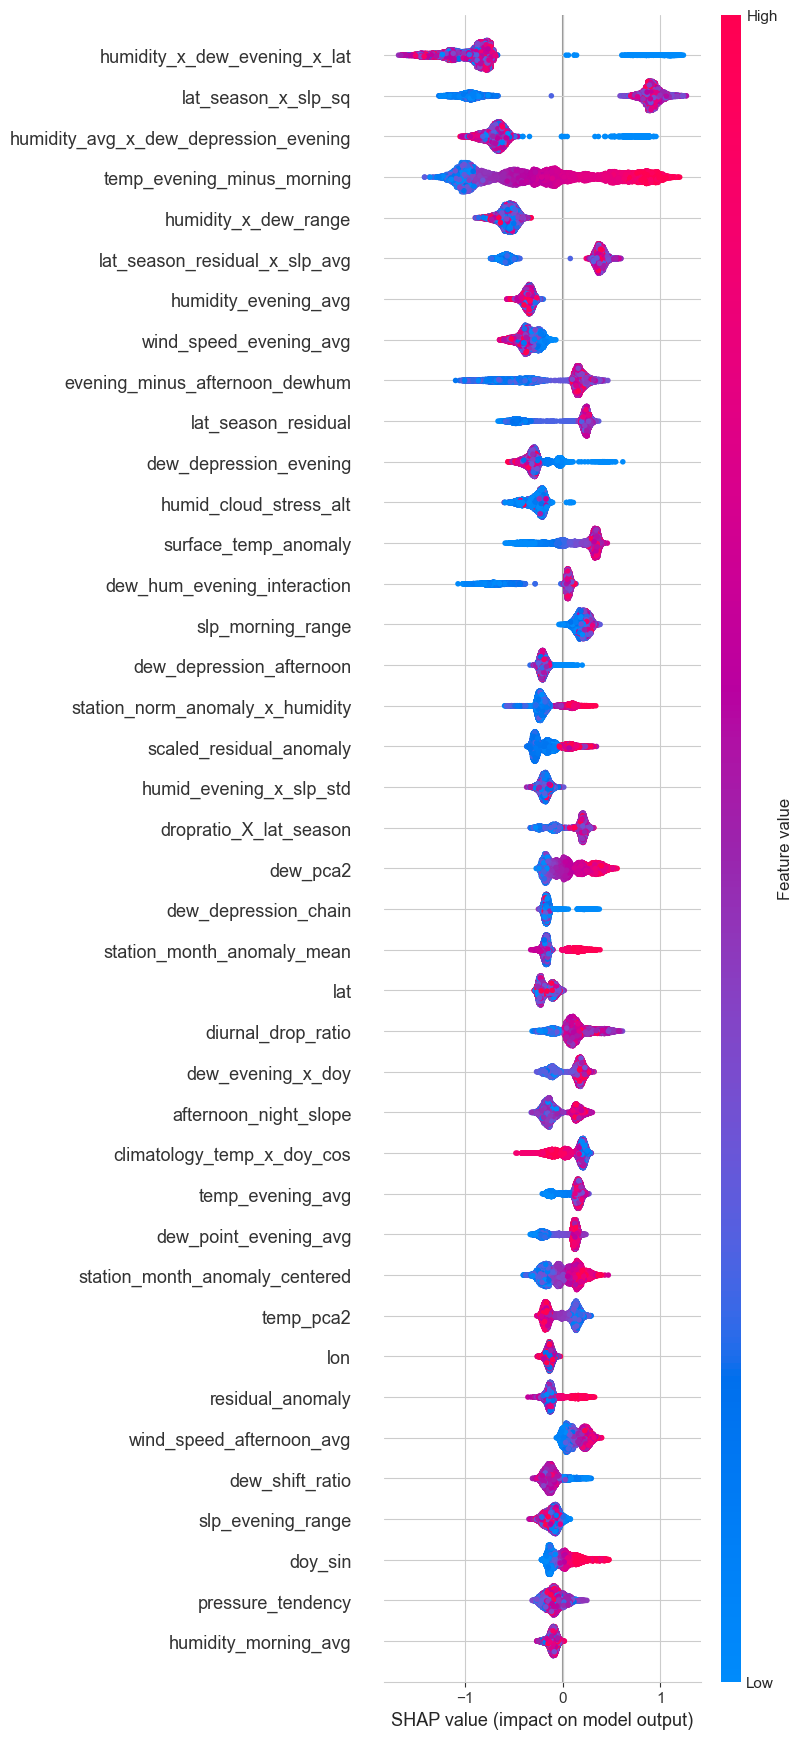

In [187]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 40

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N}  LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [188]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 40 XGB Importances (split):
lat_season_x_slp_sq                         0.180507
lat_season_residual_x_slp_avg               0.162439
humidity_x_dew_evening_x_lat                0.096576
lat_season_residual                         0.062301
humidity_avg_x_dew_depression_evening       0.024966
dew_hum_evening_interaction                 0.023601
temp_evening_minus_morning                  0.021316
station_norm_anomaly_x_humidity             0.021031
scaled_residual_anomaly                     0.020477
surface_temp_anomaly                        0.012891
evening_minus_afternoon_dewhum              0.010783
lon                                         0.009547
humidity_avg_x_dew_depression_evening_sq    0.009121
humidity_evening_avg                        0.008732
dropratio_X_lat_season                      0.008409
dp_evening_avg                              0.007836
station_month_anomaly_mean                  0.007343
humidity_cloud_dew_combo                    0.007209
dew_point_even

# Feature Selection with SHAP

In [189]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
cloud_pca2                        0.058715
dew_humidity_interaction          0.058490
climatology_temp                  0.058064
cloud_cover_evening_avg           0.057187
day_length                        0.056362
hum_pca1                          0.056173
slp_morning_avg                   0.053964
dew_point_morning_avg             0.052836
dew_point_night_avg               0.051942
wind_pca2                         0.047724
slp_std                           0.047591
surface_temp_avg                  0.043757
cloud_cover_afternoon_avg         0.043500
humidity_night_avg                0.041594
cloud_cover_afternoon_var         0.038433
slp_evening_avg                   0.037369
dew_hum_night_interaction         0.034929
dew_depression_morning            0.032176
temp_morning_avg                  0.030931
cloud_cover_evening_var           0.030828
precip_total_night                0.030078
dew_point_avg                     0.029838
slp_avg                      

# Predict with Test Dataset

In [190]:
y_test_pred = xgb_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_{now}.csv', index=False)

In [191]:
from sklearn.neural_network import MLPRegressor

X_train_df = pd.DataFrame(X_train, columns=feat_shap_imp.index)
X_val_df = pd.DataFrame(X_val, columns=feat_shap_imp.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feat_shap_imp.index)

top_features = feat_shap_imp.sort_values(ascending=False).head(top_N).index.tolist()

X_train_top = X_train_df[top_features]
X_val_top = X_val_df[top_features]
X_test_top = X_test_df[top_features]

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_top, y_train)
residuals = y_train - xgb_model.predict(X_train_top)

# Step 2: Fit NN to residuals
res_net = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    alpha=1e-3,
    max_iter=300,
    early_stopping=True,
    random_state=42
)
res_net.fit(X_train_top, residuals)

# Step 3: Predict corrected
y_pred_xgb = xgb_model.predict(X_val_top)
res_correction = res_net.predict(X_val_top)
y_pred = y_pred_xgb + res_correction

r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB + NN R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB + NN R²: 0.7723 | RMSE: 1.4289


In [192]:
y_test_pred = xgb_model.predict(X_test_top) + res_net.predict(X_test_top)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_nn_{now}.csv', index=False)

In [193]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb

# Prepare data
top_features = feat_shap_imp.sort_values(ascending=False).head(top_N).index.tolist()

X_train_df = pd.DataFrame(X_train, columns=feat_shap_imp.index)
X_val_df = pd.DataFrame(X_val, columns=feat_shap_imp.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feat_shap_imp.index)

X_train_top = X_train_df[top_features]
X_val_top = X_val_df[top_features]
X_test_top = X_test_df[top_features]

# Step 1: Train XGB
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_top, y_train)
residuals = y_train - xgb_model.predict(X_train_top)

# Convert to tensors
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_top.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_top.values, dtype=torch.float32).to(device)
residual_tensor = torch.tensor(residuals, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# Step 2: Define NN
class ResidualNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

model = ResidualNN(X_train_tensor.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Step 3: Train
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, residual_tensor)
    loss.backward()
    optimizer.step()

# Step 4: Inference
model.eval()
with torch.no_grad():
    xgb_pred = xgb_model.predict(X_val_top)
    nn_corr = model(X_val_tensor).cpu().numpy().flatten()
    final_pred = xgb_pred + nn_corr

# Step 5: Metrics
r2 = r2_score(y_val, final_pred)
rmse = root_mean_squared_error(y_val, final_pred)
print(f"\n✅ XGB + PyTorch NN R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB + PyTorch NN R²: 0.7729 | RMSE: 1.4269


In [194]:
X_test_tensor = torch.tensor(X_test_top.values, dtype=torch.float32).to(device)

y_pred_xgb_test = xgb_model.predict(X_test_top)

residual_correction_test = res_net.predict(X_test_top)

y_pred_test = y_pred_xgb_test + residual_correction_test

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_torch_{now}.csv', index=False)

In [195]:
top_features

['humidity_x_dew_evening_x_lat',
 'lat_season_x_slp_sq',
 'humidity_avg_x_dew_depression_evening',
 'temp_evening_minus_morning',
 'humidity_x_dew_range',
 'lat_season_residual_x_slp_avg',
 'humidity_evening_avg',
 'wind_speed_evening_avg',
 'evening_minus_afternoon_dewhum',
 'lat_season_residual',
 'dew_depression_evening',
 'humid_cloud_stress_alt',
 'surface_temp_anomaly',
 'dew_hum_evening_interaction',
 'slp_morning_range',
 'dew_depression_afternoon',
 'station_norm_anomaly_x_humidity',
 'scaled_residual_anomaly',
 'humid_evening_x_slp_std',
 'dropratio_X_lat_season',
 'dew_pca2',
 'dew_depression_chain',
 'station_month_anomaly_mean',
 'lat',
 'diurnal_drop_ratio',
 'dew_evening_x_doy',
 'afternoon_night_slope',
 'climatology_temp_x_doy_cos',
 'temp_evening_avg',
 'dew_point_evening_avg',
 'station_month_anomaly_centered',
 'temp_pca2',
 'lon',
 'residual_anomaly',
 'wind_speed_afternoon_avg',
 'dew_shift_ratio',
 'slp_evening_range',
 'doy_sin',
 'pressure_tendency',
 'humidity

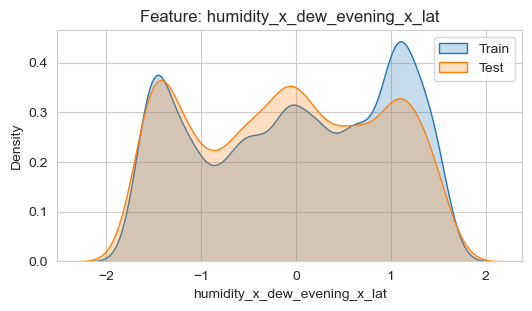

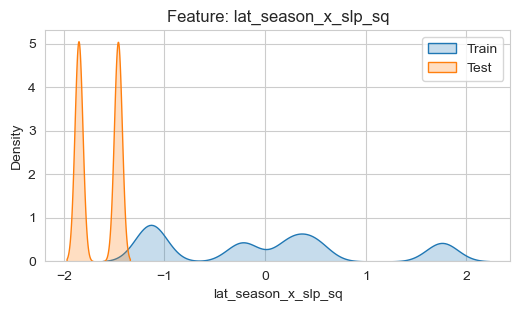

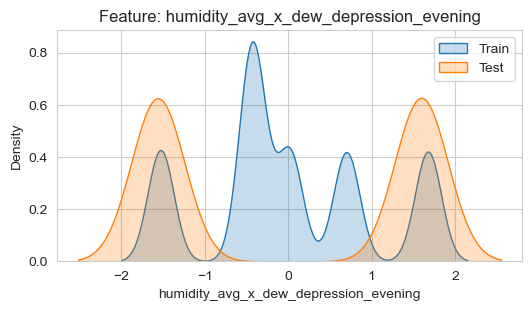

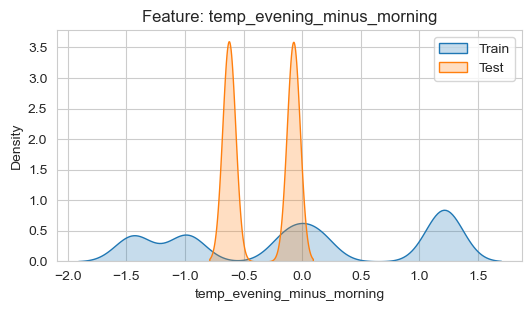

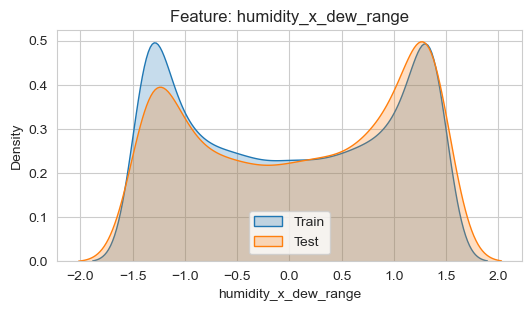

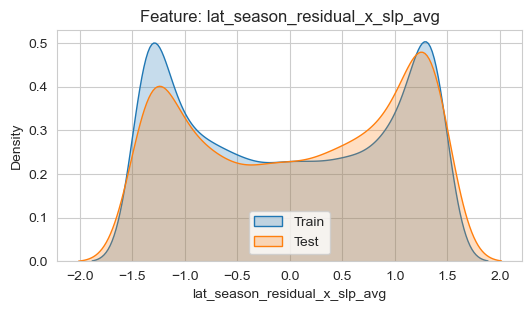

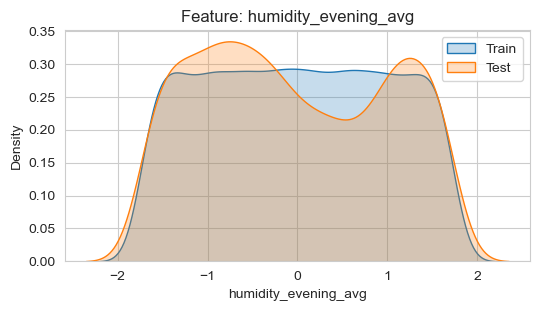

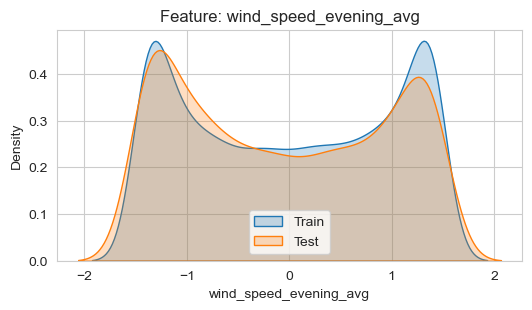

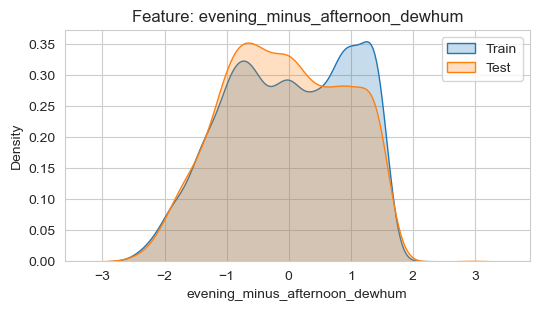

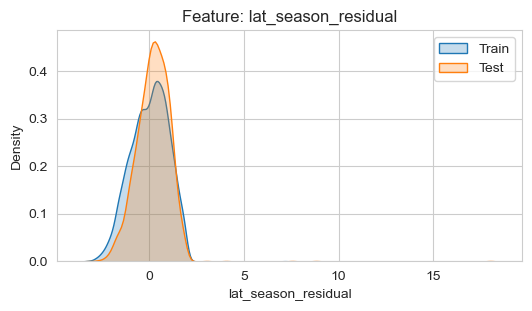

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in top_features[:10]:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(X_train_df[col], label="Train", shade=True)
    sns.kdeplot(X_test_df[col], label="Test", shade=True)
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.show()

In [197]:
train_corrs = X_train_df[top_features].corrwith(pd.Series(y_train, name="target"))
# If you have test target (e.g., CV-split)
test_corrs = X_test_df[top_features].corrwith(pd.Series(y_val, name="target"))

drift = (train_corrs - test_corrs).abs().sort_values(ascending=False)
print("Top correlation drifts:\n", drift.head())

Top correlation drifts:
 afternoon_night_slope    0.459689
pressure_tendency        0.265152
dew_point_evening_avg    0.237258
lon                      0.178265
humidity_morning_avg     0.169554
dtype: float64


In [198]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_all = pd.concat([X_train_df, X_test_df])
y_domain = np.array([0]*len(X_train_df) + [1]*len(X_test_df))

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_all, y_domain)
probs = clf.predict_proba(X_all)[:, 1]

auc = roc_auc_score(y_domain, probs)
print(f"Train/Test classifier AUC: {auc:.4f}")

Train/Test classifier AUC: 1.0000


In [199]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train_df, y_train)
mi_series = pd.Series(mi, index=X_train_df.columns).sort_values(ascending=False)
print("Top Mutual Info features:\n", mi_series.head(10))

Top Mutual Info features:
 cloud_cover_afternoon_avg        0.213986
cloud_cover_evening_var          0.158301
lat_season_residual_x_slp_avg    0.157518
temp_morning_avg                 0.153881
afternoon_night_slope            0.153003
humidity_evening_avg             0.150102
wind_speed_night_avg             0.149428
humidity_x_dew_evening_x_lat     0.148854
dew_depression_morning           0.148081
humidity_range                   0.144364
dtype: float64


In [200]:
train_df_final.columns.to_list()

['id',
 'climatology_temp',
 'target',
 'elev',
 'lat',
 'lon',
 'doy_sin',
 'doy_cos',
 'day_of_year',
 'day_length',
 'dew_point_avg',
 'humidity_avg',
 'dew_point_range',
 'humidity_range',
 'dew_humidity_interaction',
 'dew_point_night_avg',
 'humidity_night_avg',
 'dew_hum_night_interaction',
 'dew_point_morning_avg',
 'humidity_morning_avg',
 'dew_hum_morning_interaction',
 'dew_point_afternoon_avg',
 'humidity_afternoon_avg',
 'dew_hum_afternoon_interaction',
 'dew_point_evening_avg',
 'humidity_evening_avg',
 'dew_hum_evening_interaction',
 'surface_temp_avg',
 'surface_temp_anomaly',
 'temp_night_avg',
 'dp_night_avg',
 'dew_depression_night',
 'temp_morning_avg',
 'dp_morning_avg',
 'dew_depression_morning',
 'temp_afternoon_avg',
 'dp_afternoon_avg',
 'dew_depression_afternoon',
 'temp_evening_avg',
 'dp_evening_avg',
 'dew_depression_evening',
 'temp_evening_minus_morning',
 'slp_avg',
 'slp_std',
 'pressure_tendency',
 'slp_night_avg',
 'slp_night_range',
 'slp_morning_avg